# Assignment 1: 2D radioactive lighthouse location using MCMC

As before, a radioactive source that emits gamma rays randomly in time but uniformly in angle is placed at $(x_0, y_0)$.  The gamma rays are detected on the $x$-axis and these positions are saved, $x_k$, $k=1,2,\cdots, N$.  Given these observed positions, the problem is to estimate the location of the source.

Unlike before, we will not assume that $y_0$ is known. Your task is to estimate both $x_0$ and $y_0$.  Since we are using Bayesian methods, this means finding the joint posterior for $x_0$ and $y_0$, given the data on where the gamma rays were detected.

You will combine the results and Python code from the `radioactive_lighthouse_exercise.ipynb` and `parameter_estimation_Gaussian_noise.ipynb` notebooks, sampling the posterior using `emcee` and plotting it using `corner`.


## Expressions

The posterior we want is:

$$ p(x_0, y_0 | \{x_k\}, I) = \frac{p(\{x_k\} | x_0, y_0, I) p(x_0,y_0|I)}{p(\{x_k\} |I)} 
$$

*Using $\LaTeX$, fill in the right side of the equation for Bayes' rule as it applies in this case.* 


*Then add below the expression for the likelihood in this case (replace the dots with the correct form and fill in the right side):*

$$  p(\{x_k\} | x_0,y_0,I) \: {=}\prod_{k=0}^{k=N}  \frac{y_0}{\pi} \frac{1}{y_0^2 + (x_k - x_0)^2}
$$


*Describe in words what you will use for the prior:*

We are going to assume a uniform and flat prior in a posible range of values for the position $x_0$ and $y_0$. (non informative prior) 

*Do you need to find an expression for the denominator pdf?  Explain.*

No. Denominator does not depend on the $x_0$ and $y_0$ and we are interested about the distribution of $x_0$ ,$y_0$. These are the variables in the problem.  So in this problem denominator is just a normalization constant. 

## Python imports

You will need to import emcee and corner.  The best way to do this is to follow the instructions for making an environment (see Carmen page).  An alternative is to install them separately using (at the command line):

`conda install -c astropy emcee`

`conda install -c astropy corner`

In [1]:
# Copy to here all of the Python imports you think will be relevant

%matplotlib inline   

import emcee
import numpy as np

import scipy.stats as stats
from scipy.stats import cauchy, uniform

import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
import math
import corner


## Generating the data

Copy-and-paste here the code from `radioactive_lighthouse_exercise.ipynb` used to generate the $x_k$ points.  Note that you have control over where the true position is but also the size of the dataset.  You will want to adjust both later. It is recommended to add the code that plots the distribution of the data (to verify it is the same as before), but this is not required.

maximum =  554.914216974186
minimum =  -10492.161570036526


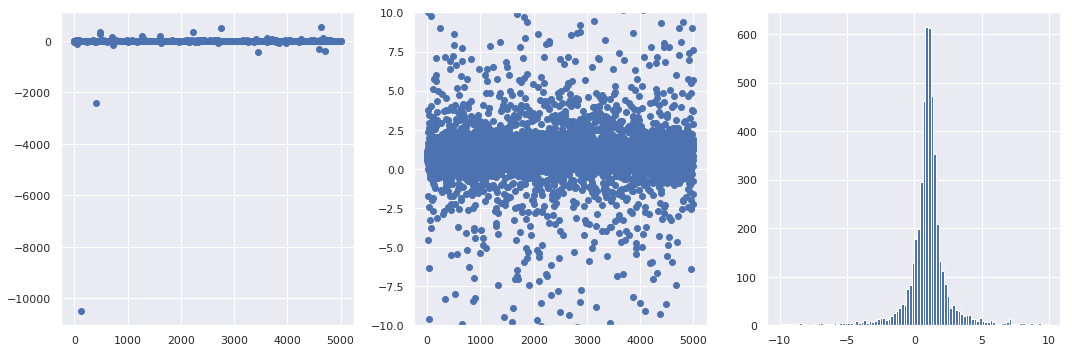

In [2]:
# Add code here to generate the dataset.  Start with 500 points.
# True location of the radioactive source
x0_true = 1.
y0_true = 0.5

# Generate num_pts random numbers distributed according to dist and plot 
num_pts = 5000
x_pts = np.arange(num_pts)

# Distribution knowing where the source is: scipy.stats.cauchy(loc, scale)
dist = cauchy(x0_true, y0_true)
dist_pts = dist.rvs(num_pts)  

# Make some plots!
fig = plt.figure(figsize=(15,5))

# First plot all the points, letting it autoscale the counts
ax_1 = fig.add_subplot(1,3,1)
ax_1.scatter(x_pts, dist_pts)  

# Repeat but zoom in to near the origin
ax_2 = fig.add_subplot(1,3,2)
ax_2.scatter(x_pts, dist_pts)
ax_2.set_ylim(-10.,10.)

# Finally make a zoomed-in histogram
ax_3 = fig.add_subplot(1,3,3)
out = ax_3.hist(dist_pts, bins=np.arange(-10., 10., 0.2))

# Print out the numerical limits (max and min)
print('maximum = ', np.amax(dist_pts))
print('minimum = ', np.amin(dist_pts))

fig.tight_layout()

## PDFs for applying Bayes' rule

*Adapt code from the two notebooks to express the logarithms of the prior, likelihood, and posterior for this case.*

In [3]:
# Add code for the log_prior, log_likelihood, and log_posterior
def log_prior(x0, y0, x_min=-4., x_max=+4.,y_min=0.,y_max=4.):
    """
    Log uniform prior from x_min to x_max.  Not normalized!
    """
    if (x0 > x_min) and (x0 < x_max) and (y0 > y_min) and (y0 < y_max):
        return 0.
    else:
        return -np.inf    # log(0) = -inf
    
def log_likelihood(x0, y0, dist_pts, N_max): 
    """
    Log likelihood for the first N_max points of the dist_pts array,
    assuming independent.  Not normalized!  
    """
    L_pts =-np.log(y0**2 + (dist_pts[0:N_max] - x0)**2)
    return (N_max*np.log(abs(y0))+sum(L_pts))


def posterior_calc_2d(x_y, dist_pts, N_max, x0_min=-4., x0_max=+4.,log=True):
    
    """
    Calculate the log posterior for a set of x0,y0  and a
    list of N_max x_k observations (dist_pts).
    """    
    log_L_pts =log_likelihood(x_y[0],x_y[1], dist_pts, N_max) 
    if (log == False):
        log_L_pts -= np.amax(log_L_pts)  # subtract maximum of log likelihood

    log_prior_pts = log_prior(x_y[0],x_y[1], x0_min, x0_max) 
    log_posterior= np.array(log_L_pts+log_prior_pts)
    posterior_pts = np.exp(log_prior_pts + log_L_pts)
    if (log == False):
        return posterior_pts
    elif (log == True):
        #print(log_posterior)
        return log_posterior

## Run MCMC

*Copy code to run `emcee` and make any necessary changes.*

In [4]:
# Add the code to run emcee
def get_posterior_draws_2d(detected_points,N_max,nsamples,nburnin,nwalkers,log_post_func, x0_min=-4., x0_max=+4.,y0_min=0.,y0_max=4.,log_post=True):
    """
    This gives you the samples drawn from the posterior distribution using MCMC
    """
    ndim = 2
    sampler2d = emcee.EnsembleSampler(nwalkers, ndim,log_post_func, args=[detected_points, N_max, x0_min, x0_max,log_post])
    mul1=np.array([x0_max-x0_min,y0_max-y0_min])
    mul2=np.random.rand(nwalkers,ndim)
    p00=[[x0_min+mul1[0]*x,y0_min+mul1[1]*y] for (x,y) in mul2]
    p0 = np.array(p00)
    out_post = sampler2d.run_mcmc(p0,nsamples)
    samples = sampler2d.chain[:, nburnin:, :]
#    print(out_post)
    return samples,p0

In [7]:
xxxx2d,start=get_posterior_draws_2d(detected_points=dist_pts,N_max=500,nsamples=2000,nburnin=1000,nwalkers=50,log_post_func=posterior_calc_2d)

## Generate figures

Note: you do not need to do the maximum likelihood estimates that were added to the corner plot for the Gaussian noise case.  You can skip that part of the code.

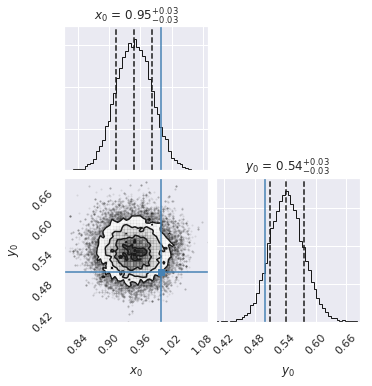

In [8]:
# Add the code to make a corner plot
samples=xxxx2d.reshape(-1, 2)
# make a corner plot with the posterior distribution
fig = corner.corner(samples, bins=50,labels=["$x_0$", "$y_0$"],truths=[x0_true, y0_true],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

## Analysis

Summarize the results for the following investigations.  You can simply add to the cell containing the question or else start new cells.

1. *Run the notebook 10 times (which will generate 10 different sets of random data).  Record the values of $x_0$ and $y_0$ and their uncertainties given on the corner plot for each run.  Is the actual spread of values consistent with the given uncertainties?*

2. *Increase the number of data points by a factor of 10.  By how much does the width of the posterior shrink?  Is this expected?*

When I increase the number of data points from 500 to 5000 width (standard deviation) went from 0.03 to 0.01. so It shrink by $\sqrt{10}$ . Width is propotianal to the squre root of the number of data points. This makes sense 

3. *What does increasing the number of MC steps per walker do?*

It gets you more samples from the posterior. 

4. *Try changing `x0_true` and `y0_true`.  Does it still work?*

Yes